# Dyadic citation frequencies
In this notebook, we'll explore the frequency of citations within and across the kingdom classes of the citation network.

In [72]:
import networkx as nx
import sys
sys.path.append('../citation_network/')
import utils
import matplotlib.pyplot as plt
%matplotlib inline

## Read in the graph

In [2]:
graph = nx.read_graphml('../data/citation_network/core_collection_destol_or_anhydro_FILTERED_classified_network_06Jan2023.graphml')

## Calculate frequencies

In [3]:
dyadic_freqs = utils.calculate_dyadic_citation_freqs(graph)

## Visualize
To visualize, we'll create a graph with one node to represent each study system, and then visualize the citation frequencies between nodes as edges with varying weights.

In [58]:
colors = {'Plant': '#648FFF', 'Animal':'#785EF0', 'Microbe': '#DC267F', 'Fungi':'#FE6100', 'NOCLASS':'#FFB000'}

In [59]:
nodes = list(set([k[0] for k in dyadic_freqs.keys()]))
nodes = [(n, {'color': colors[n]}) for n in nodes]
nodes

[('Plant', {'color': '#648FFF'}),
 ('Animal', {'color': '#785EF0'}),
 ('Microbe', {'color': '#DC267F'}),
 ('Fungi', {'color': '#FE6100'}),
 ('NOCLASS', {'color': '#FFB000'})]

In [64]:
edges = [(k[0], k[1], {'weight': round(v, 2)*10, 'color': colors[k[0]]}) for k, v in dyadic_freqs.items()]
edges[:5]

[('Plant', 'Plant', {'weight': 8.299999999999999, 'color': '#648FFF'}),
 ('Plant', 'Animal', {'weight': 0.3, 'color': '#648FFF'}),
 ('Plant', 'Microbe', {'weight': 0.5, 'color': '#648FFF'}),
 ('Plant', 'Fungi', {'weight': 0.1, 'color': '#648FFF'}),
 ('Plant', 'NOCLASS', {'weight': 0.8999999999999999, 'color': '#648FFF'})]

In [78]:
dyadic_freq_graph = nx.MultiDiGraph()
_ = dyadic_freq_graph.add_nodes_from(nodes)
_ = dyadic_freq_graph.add_edges_from(edges)

/tmp/local/28850192/ipykernel_15038/1350712311.py:9: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  _ = nx.draw_networkx_edges(dyadic_freq_graph, pos, width=weights, edge_color=edge_colors, connectionstyle='arc3, rad = 0.1')


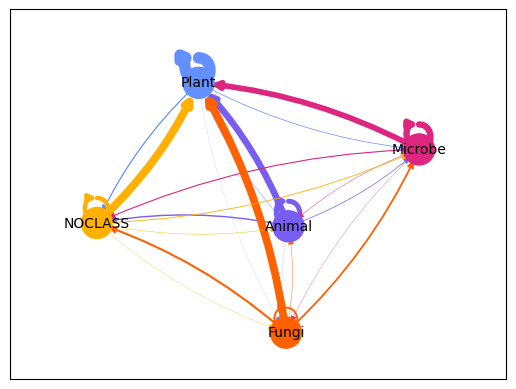

In [79]:
nodes = dyadic_freq_graph.nodes(data=True)
node_colors = [attrs['color'] for n, attrs in nodes]
edges = dyadic_freq_graph.edges(data=True)
edge_colors = [attrs['color'] for e1, e2, attrs in edges]

plt.margins(x=0.2)
pos = nx.spring_layout(dyadic_freq_graph, seed=3)
nx.draw_networkx_nodes(dyadic_freq_graph, pos, node_size=500, node_color=node_colors)
_ = nx.draw_networkx_edges(dyadic_freq_graph, pos, width=weights, edge_color=edge_colors, connectionstyle='arc3, rad = 0.1')
_ = nx.draw_networkx_labels(dyadic_freq_graph, pos, font_size=10, font_family="sans-serif")